In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/Othercomputers/Desktop_Vivian/Vanderbilt/CS8395/SmartCityDisasterAnalysis

/content/gdrive/Othercomputers/Desktop_Vivian/Vanderbilt/CS8395/SmartCityDisasterAnalysis


In [12]:

# install
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import tensorflow as tf

import nltk 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla P100-PCIE-16GB'

In [20]:
twitter = pd.read_csv("./data/demands.csv", index_col=0)
sent = pd.read_csv("./data/sentiment140_sentiment.csv", index_col=0)
target_df = pd.merge(twitter, sent, on = "Tweet Id")

In [26]:
import string as st
lemmatizer = WordNetLemmatizer()
stopword = nltk.corpus.stopwords.words('english')
def pre_processing(text):
    a = [w for w in text if w not in st.punctuation]
    text = ''.join(a)
    texts = nltk.word_tokenize(text)
    a = [w for w in texts if w not in stopword]
    a = [x.lower() for x in a]
    a = [i for i in a if not i.isdigit()]
    
    a = [lemmatizer.lemmatize(w) for w in a]
    return ' '.join(a)


In [86]:
def label_need (row):
    if row['Sentiment140_Sentiment']==0:
        if row['Demand'] == "Water":
            return "Water"
        elif row['Demand'] == "Food":
            return "Food"
        elif row['Demand'] == "Shelter":
            return "Shelter"
        elif row['Demand'] == "Medicine":
            return "Medicine"
        elif row['Demand'] == "Electricity":
            return "Electricity"
        else:
          return "No Need"
    else:
        return "No Need"

In [21]:


needs = target_df[target_df["Demand"] != 'Other']
needs['Label'] = needs.apply (lambda row: label_need(row), axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
needs = needs[needs['CleanText'].notna()]
needs['CleanText'] = needs['CleanText'].apply(pre_processing)

In [73]:
tweets = needs['CleanText']
labels = needs[['Label']].replace(['No Need','Electricity','Food', 'Shelter', 'Water', 'Medicine'],[0,1,2,3,4,5]) 


# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in tweets]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['new', 'york', 'ag', 'suggests', 'emergency', 'housing', 'basement', 'dwell', '##er', 'city', 'ida', 'death']


In [74]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [75]:

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [80]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels.to_numpy())
validation_labels = torch.tensor(validation_labels.to_numpy())
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [82]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.cuda()

100%|██████████| 407873900/407873900 [00:14<00:00, 28990264.89B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.30261023133877185


Epoch:   5%|▌         | 1/20 [02:08<40:50, 128.99s/it]

Validation Accuracy: 0.8183950304259635
Train loss: 0.15238368355737933


Epoch:  10%|█         | 2/20 [04:18<38:42, 129.01s/it]

Validation Accuracy: 0.8246069979716024
Train loss: 0.09212103317915697


Epoch:  15%|█▌        | 3/20 [06:27<36:33, 129.03s/it]

Validation Accuracy: 0.81598630831643
Train loss: 0.05105491623315047


Epoch:  20%|██        | 4/20 [08:35<34:23, 128.99s/it]

Validation Accuracy: 0.8202966531440162
Train loss: 0.034789109247435855


Epoch:  25%|██▌       | 5/20 [10:45<32:14, 129.00s/it]

Validation Accuracy: 0.8170638945233266
Train loss: 0.028650269653387222


Epoch:  30%|███       | 6/20 [12:53<30:05, 128.99s/it]

Validation Accuracy: 0.8061612576064909
Train loss: 0.02082670735220646


Epoch:  35%|███▌      | 7/20 [15:02<27:56, 128.98s/it]

Validation Accuracy: 0.81598630831643
Train loss: 0.019083553415103472


Epoch:  40%|████      | 8/20 [17:12<25:48, 129.03s/it]

Validation Accuracy: 0.8277129817444219
Train loss: 0.017683821771310185


Epoch:  45%|████▌     | 9/20 [19:21<23:39, 129.03s/it]

Validation Accuracy: 0.8255578093306288
Train loss: 0.018203838825079064


Epoch:  50%|█████     | 10/20 [21:30<21:29, 129.00s/it]

Validation Accuracy: 0.8266353955375254
Train loss: 0.01916642549469458


Epoch:  55%|█████▌    | 11/20 [23:39<19:21, 129.00s/it]

Validation Accuracy: 0.8299949290060852
Train loss: 0.012960926643871714


Epoch:  60%|██████    | 12/20 [25:47<17:11, 128.94s/it]

Validation Accuracy: 0.8137043610547667
Train loss: 0.01580268637538101


Epoch:  65%|██████▌   | 13/20 [27:57<15:03, 129.01s/it]

Validation Accuracy: 0.8190922920892495
Train loss: 0.012528522623655775


Epoch:  70%|███████   | 14/20 [30:06<12:54, 129.02s/it]

Validation Accuracy: 0.8201698782961461
Train loss: 0.012978728739784827


Epoch:  75%|███████▌  | 15/20 [32:15<10:45, 129.05s/it]

Validation Accuracy: 0.8170638945233266
Train loss: 0.01357582802653262


Epoch:  80%|████████  | 16/20 [34:24<08:36, 129.07s/it]

Validation Accuracy: 0.8202966531440162
Train loss: 0.012107886329944634


Epoch:  85%|████████▌ | 17/20 [36:33<06:27, 129.05s/it]

Validation Accuracy: 0.81598630831643
Train loss: 0.009798137424649592


Epoch:  90%|█████████ | 18/20 [38:42<04:17, 129.00s/it]

Validation Accuracy: 0.8213742393509128
Train loss: 0.007551564147108386


Epoch:  95%|█████████▌| 19/20 [40:50<02:08, 128.94s/it]

Validation Accuracy: 0.8202966531440162
Train loss: 0.00870984791531608


Epoch: 100%|██████████| 20/20 [42:59<00:00, 128.99s/it]

Validation Accuracy: 0.8279665314401623


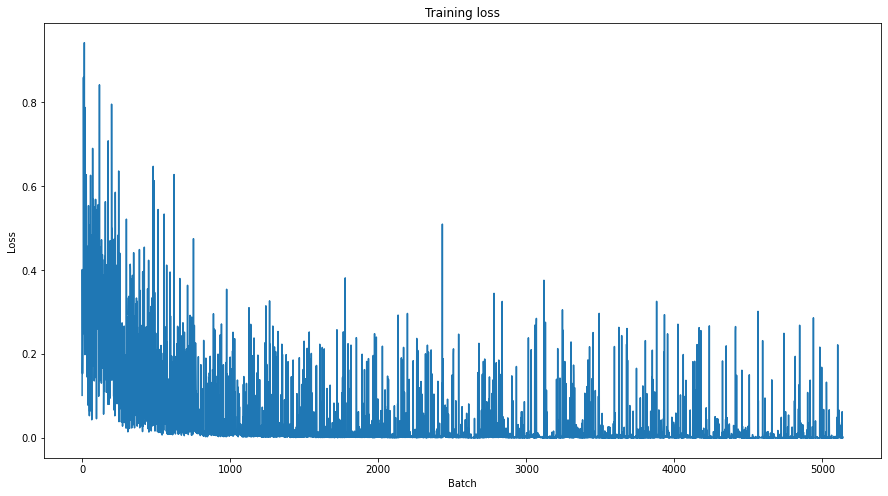

In [84]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 20

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [87]:
other = target_df[target_df["Demand"] == 'Other']
other['Label'] = other.apply (lambda row: label_need(row), axis=1)
other = other[other['CleanText'].notna()]
other['CleanText'] = other['CleanText'].apply(pre_processing)
other

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Datetime,Tweet Id,Text,Username,Location,FollowersCount,ReplyCount,RetweetCount,Dates,Time,CleanText,Demand,Sentiment140_Sentiment,Label
0,2021-09-03 23:59:59+00:00,1433942885716615173,"@POTUS flying entourage over W Jeff Parish, su...",AnthonyMcAuley2,World,443,0,0,2021-09-03,23:59:59,flying entourage w jeff parish surveying downe...,Other,0,No Need
1,2021-09-03 23:59:19+00:00,1433942716996485123,"Air operations underway @ Grand Isle, LA #Hurr...",ClarkCountyNV,"Las Vegas, Nevada",217434,0,1,2021-09-03,23:59:19,air operation underway grand isle la,Other,4,No Need
2,2021-09-03 23:58:58+00:00,1433942626944884738,I signed up to volunteer by helping man the co...,dikayodata,⚜️🛫⛩,6175,0,0,2021-09-03,23:58:58,i signed volunteer helping man cooling station...,Other,4,No Need
4,2021-09-03 23:57:08+00:00,1433942167152697346,Dammit bobby!\n#HurricaneIda https://t.co/6ljX...,NoTangledKnots,NaN,178,0,0,2021-09-03,23:57:08,dammit bobby,Other,0,No Need
5,2021-09-03 23:56:42+00:00,1433942058495004676,"The ""remnants"" of #HurricaneIda killed more pe...",RogueSailor,⚓ Lost @ Sea ⚓,8771,0,0,2021-09-03,23:56:42,the remnant killed people hurricane,Other,0,No Need
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42533,2021-08-26 15:46:12+00:00,1430919515127300098,#HURRICANEIDA Watch! FULL #VIDEO BREAKDOWN Now...,In2ThinAir,"North East, US",767,0,0,2021-08-26,15:46:12,watch full breakdown now soon 2b may see via,Other,4,No Need
42535,2021-08-26 15:06:29+00:00,1430909520868433920,@NHC_Atlantic forecasts TD Nine to become #Hur...,TylerJStanfield,"Blacksburg, VA",1857,0,0,2021-08-26,15:06:29,forecast td nine become saturday explicitly sh...,Other,0,No Need
42537,2021-08-26 14:47:45+00:00,1430904806038642696,@ezrocks0011 @mal1976retaf @Lisaisback21 @fric...,enufs_enuf,Nunya TX,1228,1,2,2021-08-26,14:47:45,btw upgraded will probably within next couple ...,Other,4,No Need
42538,2021-08-26 13:28:18+00:00,1430884811292487682,Sorry not sorry.\n\n#Louisiana #SWLA #LakeChar...,unclejeet,NaN,788,0,1,2021-08-26,13:28:18,sorry sorry,Other,0,No Need


In [90]:
tweets = other['CleanText']
labels = other[['Label']].replace(['No Need','Electricity','Food', 'Shelter', 'Water', 'Medicine'],[0,1,2,3,4,5]) 


# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in tweets]


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels.to_numpy())
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))

Classification accuracy using BERT Fine Tuning: 0.00%


KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f80373e05f0> (for post_execute):


KeyboardInterrupt: ignored

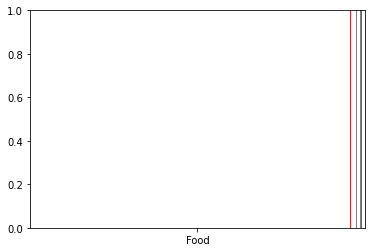

In [96]:
preds = pd.DataFrame(flat_predictions).replace([0,1,2,3,4,5], ['No Need','Electricity','Food', 'Shelter', 'Water', 'Medicine']) 
plt.hist(preds)

In [98]:
preds.value_counts()

No Need        22360
Food            9820
Water            524
Shelter          413
Electricity      248
Medicine          50
dtype: int64

In [102]:
needs['PRED'] = preds

In [103]:
needs.to_csv("./data/BERT_preds.csv")